In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
def check_varying_lmbda(X, y, regressor, lambdaa):
    global best_lambda
    final_scores={}
    for a in lambdaa:
        pipe=Pipeline([('regressor',regressor(alpha=2**a))])
        
        scores=cross_val_score(pipe,X, y,cv=5, scoring='neg_mean_squared_error')
        final_scores.update({2**a:scores.mean()})
    
    best_lambda=max(final_scores, key=final_scores.get)
    print('best lambda is:',best_lambda, 'with mean MSE of:',final_scores[best_lambda],'with STD MSE of',cross_val_score(Pipeline([('regressor',regressor(alpha=best_lambda))]),X, y,cv=5, scoring='neg_mean_squared_error').std())

    
        

In [3]:
def result(dataset):
    global w_Lasso,w_Ridge
    a=np.load(dataset)
    X_train=pd.DataFrame(a['X_train'])
    y_train=pd.DataFrame(a['y_train'])
    X_test=pd.DataFrame(a['X_test'])
    y_test=pd.DataFrame(a['y_test'])



    model=LinearRegression()
    model.fit(X_train,y_train)
    w=np.concatenate((model.intercept_, model.coef_.flatten()))
    print('OLS w is', w)
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    print('OLS train MSE is:',mean_squared_error(y_train, y_train_pred))
    print('OLS test MSE is:',mean_squared_error(y_test, y_test_pred))
    print('OLS l1 norm is:',norm(w, 1),'OLS l2 norm is:',norm(w))

    check_varying_lmbda(X_train, y_train, Lasso,np.linspace(-10,10,41))
    model=Lasso(alpha=best_lambda)
    model.fit(X_train,y_train)
    w_Lasso=np.concatenate((model.intercept_, model.coef_.flatten()))
    print('LASSO w is',w_Lasso)
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    print('LASSO train MSE is:',mean_squared_error(y_train, y_train_pred))
    print('LASSO  test MSE is:',mean_squared_error(y_test, y_test_pred))
    print('LASSO l1 norm is:',norm(w_Lasso, 1),'LASSO l2 norm is:',norm(w_Lasso))


    check_varying_lmbda(X_train, y_train, Ridge,np.linspace(-10,10,41))
    model=Ridge(alpha=best_lambda)
    model.fit(X_train,y_train)
    w_Ridge=np.concatenate((model.intercept_, model.coef_.flatten()))
    print('Ridge w is',w_Ridge)
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    print('Ridge train MSE is:',mean_squared_error(y_train, y_train_pred))
    print('Ridge  test MSE is:',mean_squared_error(y_test, y_test_pred))
    print('Ridge l1 norm is:',norm(w_Ridge, 1),'Ridge l2 norm is:',norm(w_Ridge))
    

In [4]:

def MSE(X,Y,w):
	return np.mean(np.square(np.dot(X,w)-Y))

def display(w,Xtest,Ytest,norm='l2',
	levels=None,
	w1_range=(-4.0, 6.1, 100),
	w2_range=(-4.0, 6.1, 100)):

	w = np.array(w)

	w1list = np.linspace(w1_range[0], w1_range[1], w1_range[2])
	w2list = np.linspace(w2_range[0], w2_range[1], w2_range[2])
	W1, W2 = np.meshgrid(w1list, w2list)

	Z = np.stack((w[0]*np.ones(W1.shape),W1,W2),axis=0)
	Z = Z.reshape((Z.shape[0],-1))
	Z = np.matmul(Xtest,Z) - Ytest.reshape((len(Ytest),1))
	Z = np.square(Z)
	Z = np.sum(Z, axis=0, keepdims=False)/Xtest.shape[0]
	Z = Z.reshape(W1.shape)
	
	if norm == 'l2':
		W_norm = np.square(W1) + np.square(W2)
	elif norm == 'l1':
		W_norm = np.abs(W1) + np.abs(W2)
	else:
		raise RuntimeError('Unimplemented norm. Please enter "l1" or "l2".')
		
	plt.figure()

	mse_ori = MSE(Xtest,Ytest,w)
	levels = [mse_ori, mse_ori+10]
	contour = plt.contour(W1, W2, Z, levels, colors='k')
	plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)

	if norm == 'l2':
		levels = [np.sum(np.square(w[1:]))]
	elif norm == 'l1':
		levels = [np.sum(abs(w[1:]))]
	else:
		raise RuntimeError('Unimplemented norm. Please enter "l1" or "l2".')
		
	contour = plt.contour(W1, W2, W_norm, levels, colors='r')
	plt.clabel(contour, colors = 'r', fmt = '%2.1f', fontsize=12)
	plt.plot(w[1],w[2],marker = ".",markersize=8)

	plt.title('Plot for 2D case')
	plt.xlabel('$w_1$')
	plt.ylabel('$w_2$')
	plt.axis('square')
	return


In [5]:
def plot_2D(file):
    dataset = np.load(file)
    Xtrain,Ytrain,Xtest,Ytest = dataset['X_train'],dataset['y_train'],dataset['X_test'],dataset['y_test']

    Xtrain = np.concatenate((np.ones((len(Xtrain),1)),Xtrain),axis=1)
    Xtest = np.concatenate((np.ones((len(Xtest),1)),Xtest),axis=1)



 
    display(w_Lasso,Xtrain,Ytrain,norm='l1')

    display(w_Ridge,Xtrain,Ytrain,norm='l2')
    plt.show()

In [6]:
result('dataset1_dim9_Ntr10.npz')
result('dataset2_dim9_Ntr100.npz')
result('dataset3_dim9_Ntr1000.npz')


OLS w is [ -7.01477582   3.20265861  -2.01056618   4.61891474  -8.48679639
   5.34513234  -1.36854253 -20.00142649  13.2641012    3.11232438]
OLS train MSE is: 9.365356666783853e-28
OLS test MSE is: 480.8978021950028
OLS l1 norm is: 68.42523867301658 OLS l2 norm is: 27.80269624088004
best lambda is: 4.0 with mean MSE of: -120.35818995011604 with STD MSE of 114.19046963120057
LASSO w is [ 0.12578696  2.26001059  0.         -3.34237423 -0.          5.01163416
  0.         -5.93509725 -0.          1.43300028]
LASSO train MSE is: 14.107883849225086
LASSO  test MSE is: 233.3835984423175
LASSO l1 norm is: 18.107903459292228 LASSO l2 norm is: 8.870754296600296
best lambda is: 22.627416997969522 with mean MSE of: -84.5753041414547 with STD MSE of 43.97256195045436
Ridge w is [-0.13458667  2.45289798 -0.20945981 -1.73524002 -1.56346484  2.70527836
  2.29260148 -2.95259376 -2.74902616  1.51411343]
Ridge train MSE is: 21.496921716819042
Ridge  test MSE is: 270.97166281655035
Ridge l1 norm is: 18.

OLS w is [ 6.77265711 -2.4928513   7.23801612]
OLS train MSE is: 95.38019904643616
OLS test MSE is: 163.48761227397384
OLS l1 norm is: 16.503524531665285 OLS l2 norm is: 10.221157922129624
best lambda is: 1.4142135623730951 with mean MSE of: -161.54595243084395 with STD MSE of 118.40018863689559
LASSO w is [5.40758378 0.         4.15574202]
LASSO train MSE is: 98.09379261871835
LASSO  test MSE is: 139.04677640667703
LASSO l1 norm is: 9.563325800929503 LASSO l2 norm is: 6.8199819709990335
best lambda is: 16.0 with mean MSE of: -155.9026878419882 with STD MSE of 121.95637904426236
Ridge w is [4.61680832 1.55139276 2.16748412]
Ridge train MSE is: 102.92593770240384
Ridge  test MSE is: 127.90734292133521
Ridge l1 norm is: 8.335685196859789 Ridge l2 norm is: 5.331015470702115


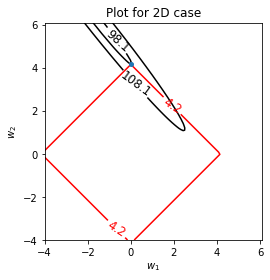

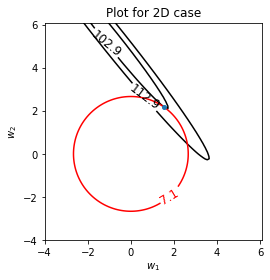

OLS w is [ 4.05510307  2.74884213 -0.29784002]
OLS train MSE is: 87.12261767437649
OLS test MSE is: 114.70433167932686
OLS l1 norm is: 7.101785217832999 OLS l2 norm is: 4.908024311927914
best lambda is: 5.656854249492381 with mean MSE of: -99.29431292631122 with STD MSE of 51.68578141571634
LASSO w is [ 3.6870101   2.37618863 -0.        ]
LASSO train MSE is: 89.72181222213327
LASSO  test MSE is: 103.6350573042968
LASSO l1 norm is: 6.06319872716057 LASSO l2 norm is: 4.386378444558678
best lambda is: 64.0 with mean MSE of: -104.57663846874671 with STD MSE of 52.505687348248756
Ridge w is [ 3.79650626  2.41954902 -0.18839922]
Ridge train MSE is: 88.86631773419619
Ridge  test MSE is: 106.00172830717882
Ridge l1 norm is: 6.404454500561942 Ridge l2 norm is: 4.505904073798311


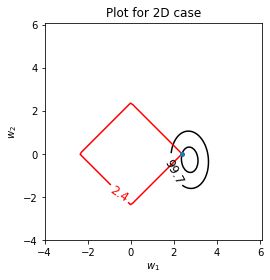

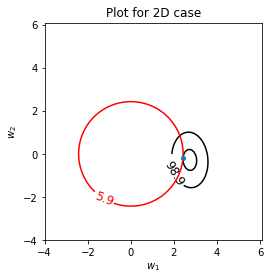

OLS w is [1.21077089 2.30240071 0.23152547]
OLS train MSE is: 101.35833777888637
OLS test MSE is: 101.4457093370796
OLS l1 norm is: 3.7446970691535286 OLS l2 norm is: 2.611631526967983
best lambda is: 0.0009765625 with mean MSE of: -110.87841697917038 with STD MSE of 27.339722364878934
LASSO w is [1.2107991  2.30236633 0.23141756]
LASSO train MSE is: 101.35833791468285
LASSO  test MSE is: 101.44595275106839
LASSO l1 norm is: 3.7445829866482643 LASSO l2 norm is: 2.6116047303958667
best lambda is: 90.50966799187809 with mean MSE of: -110.4223292969328 with STD MSE of 29.169609209886165
Ridge w is [1.22395431 2.18504022 0.24383607]
Ridge train MSE is: 101.58772152431895
Ridge  test MSE is: 101.3082994749359
Ridge l1 norm is: 3.6528306061457267 Ridge l2 norm is: 2.516330851694283


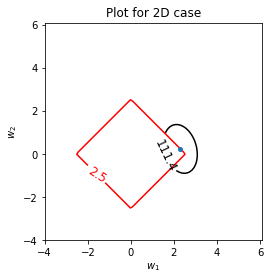

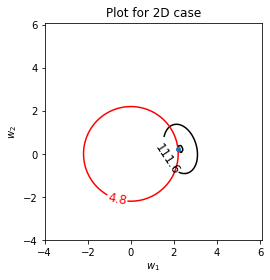

OLS w is [ 1.6193184   4.35846137 -2.05316003]
OLS train MSE is: 25.417551693358597
OLS test MSE is: 116.51141337592613
OLS l1 norm is: 8.030939797861013 OLS l2 norm is: 5.082700433707279
best lambda is: 1.4142135623730951 with mean MSE of: -61.91109702592708 with STD MSE of 51.81377203033446
LASSO w is [ 1.44203979  3.63303055 -1.21671938]
LASSO train MSE is: 27.626827689407435
LASSO  test MSE is: 105.78138791318894
LASSO l1 norm is: 6.291789728863818 LASSO l2 norm is: 4.093750824293747
best lambda is: 5.656854249492381 with mean MSE of: -54.831782966414174 with STD MSE of 53.3268705194972
Ridge w is [ 1.59787074  3.60182849 -1.32250097]
Ridge train MSE is: 27.50581291945118
Ridge  test MSE is: 107.48904375692914
Ridge l1 norm is: 6.522200204625349 Ridge l2 norm is: 4.1563647811315585


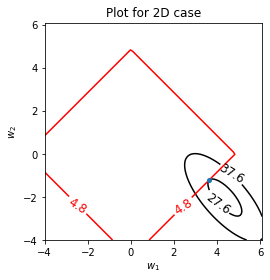

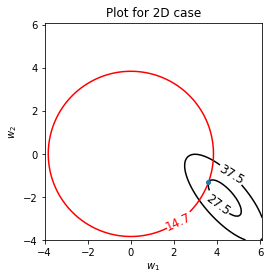

OLS w is [3.58068323 1.91863829 0.60434473]
OLS train MSE is: 95.15432277075584
OLS test MSE is: 109.24257017878496
OLS l1 norm is: 6.103666255666341 OLS l2 norm is: 4.107030295969648
best lambda is: 0.7071067811865476 with mean MSE of: -112.25807065948239 with STD MSE of 37.431892972962494
LASSO w is [3.53520373 1.89335513 0.59624288]
LASSO train MSE is: 95.17784459618632
LASSO  test MSE is: 109.38954465644765
LASSO l1 norm is: 6.0248017392607816 LASSO l2 norm is: 4.054375985065424
best lambda is: 64.0 with mean MSE of: -108.75084091972133 with STD MSE of 41.107302706474876
Ridge w is [3.20005109 1.41174703 0.97725369]
Ridge train MSE is: 95.90349733909385
Ridge  test MSE is: 110.51198296942115
Ridge l1 norm is: 5.589051809257595 Ridge l2 norm is: 3.631581118965082


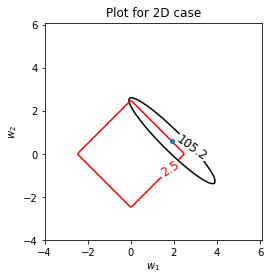

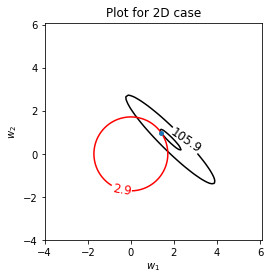

OLS w is [ 4.11404128  3.04009919 -0.51630424]
OLS train MSE is: 83.32401525715771
OLS test MSE is: 111.41165530589785
OLS l1 norm is: 7.670444709675474 OLS l2 norm is: 5.141411166840955
best lambda is: 1.0 with mean MSE of: -88.79325849350754 with STD MSE of 20.28235442339538
LASSO w is [ 4.10151715  2.50447238 -0.        ]
LASSO train MSE is: 83.90836860287891
LASSO  test MSE is: 109.50398425369923
LASSO l1 norm is: 6.60598952750575 LASSO l2 norm is: 4.80570752521165
best lambda is: 11.313708498984761 with mean MSE of: -89.34875318191997 with STD MSE of 19.68690482275225
Ridge w is [ 4.1101324   2.86266206 -0.34484516]
Ridge train MSE is: 83.38817183255067
Ridge  test MSE is: 110.60800347490775
Ridge l1 norm is: 7.3176396252729825 Ridge l2 norm is: 5.020651415930633


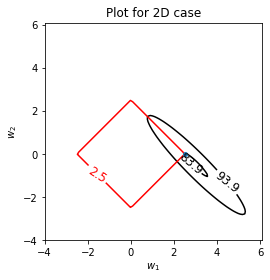

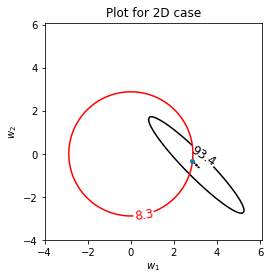

In [7]:
result('dataset4_dim2_Ntr10.npz');plot_2D('dataset4_dim2_Ntr10.npz')
result('dataset5_dim2_Ntr30.npz');plot_2D('dataset5_dim2_Ntr30.npz')
result('dataset6_dim2_Ntr100.npz');plot_2D('dataset6_dim2_Ntr100.npz')
result('dataset7_dim2_Ntr10.npz');plot_2D('dataset7_dim2_Ntr10.npz')
result('dataset8_dim2_Ntr30.npz');plot_2D('dataset8_dim2_Ntr30.npz')
result('dataset9_dim2_Ntr100.npz');plot_2D('dataset9_dim2_Ntr100.npz')